# Implement a two-layer neural network to recognize hand-written digits


In [ ]:
# Uncomment the below line and run to install required packages if you have not done so

# !pip install torch torchvision matplotlib tqdm

In [11]:
# Setup
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, utils
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

## Get MNIST Data
The `torchvision` package provides a wrapper to download MNIST data. The cell below downloads the training and test datasets and creates dataloaders for each.

In [4]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((train_mean, ), (train_std, ))
])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

Train Data: Mean=0.1306604762738429, Std=0.30810780713746055


## Part 0: Inspect dataset (0 points)

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=-0.006313480902463198, Std=0.9859887361526489


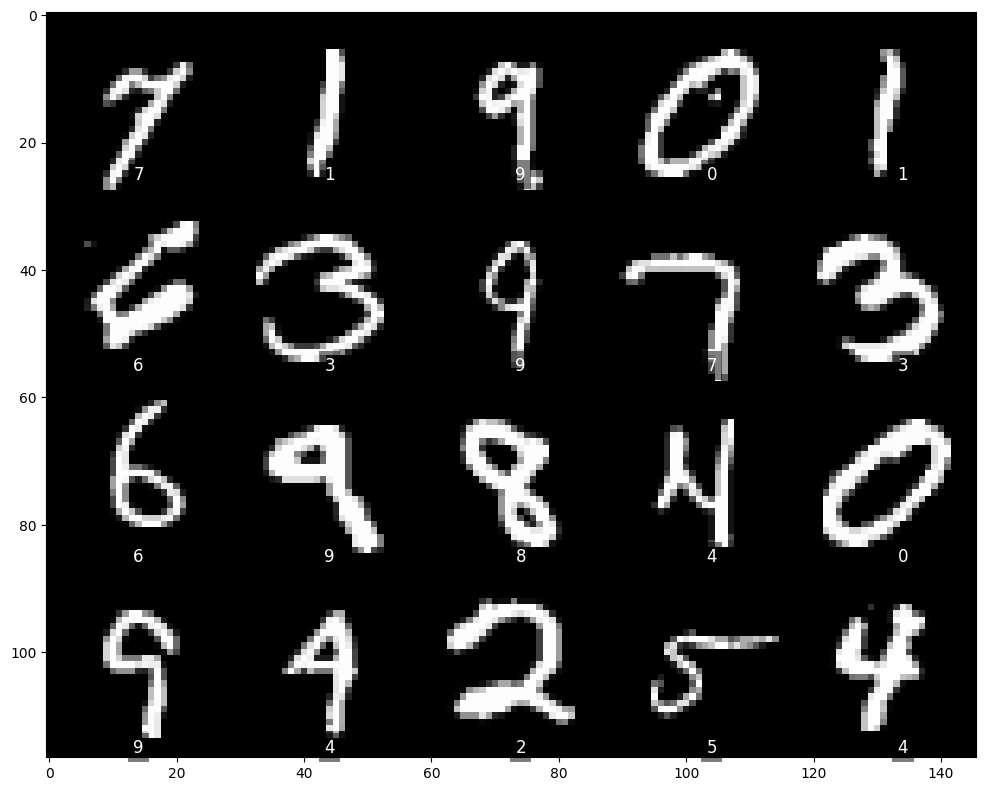

In [14]:
# Randomly sample 20 images of the training dataset
# To visualize the i-th sample, use the following code
# > plt.subplot(4, 5, i+1)
# > plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
# > plt.title(f'Label: {labels[i]}', fontsize=14)
# > plt.axis('off')

for images, labels in train_loader:
  # Print information and statistics of the first batch of images
  print("Images shape: ", images.shape)
  print("Labels shape: ", labels.shape)
  print(f'Mean={images.mean()}, Std={images.std()}')
  break

fig = plt.figure(figsize=(12, 10))

def extract_random_images(data_loader, num_images):
  all_images = []
  all_labels = []
  for image, label in data_loader:
    all_images.append(image)
    all_labels.append(label)
    if len(all_images) * batch_size > 1000:
      break
  all_images = torch.cat(all_images, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  random_choices = np.random.choice(len(all_images), num_images, replace=False)
  random_images = all_images[random_choices]
  random_labels = all_labels[random_choices]
  return random_images, random_labels


def display_images(images, labels, num_images_per_row):
  num_rows = len(images) // num_images_per_row

  grid = utils.make_grid(images, nrow=num_images_per_row, padding=True, normalize=True)
  # this gives a 4D tensor of shape (BxCxHxW) - Convert grid to Numpy Array and transpose image.
  # Images in pytorch are in the format (CxHxW) which need to be converted into matlab's format (HxWxC).
  grid_np = grid.numpy().transpose((1, 2, 0))

  plt.imshow(grid_np)
  for i in range(len(images)):
    row = i // num_images_per_row
    col = i % num_images_per_row

    label_name = labels[i].item()
    # adding label name as text to plot
    plt.text(
        col * (images.shape[3] + 2) + images.shape[3] // 2,
        (row + 1) * (images.shape[2] + 2) - 5,
        label_name,
        fontsize=12,
        ha="center",
        va="center",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5, lw=0),
    )

rnd_images, rnd_labels = extract_random_images(train_loader, 20)
display_images(rnd_images, rnd_labels, 5)

## Part 1: Implement a two-layer neural network

Write a class that constructs a two-layer neural network. The class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

In [16]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class MNISTClassifierMLP(torch.nn.Module):

    def __init__(self):

        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        # ------------------
        # Write your implementation here.

        self.fc1 = torch.nn.Linear(784, 128)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128, 10)
        self.log_softmax = torch.nn.LogSoftmax()

        # ------------------

    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1
        x = self.flatten(x)

        # ------------------
        # Write your implementation here.
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        y_output = x
        return y_output
        # ------------------

model = MNISTClassifierMLP().to(DEVICE)

# sanity check
print(model)

MNISTClassifierMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)


## Part 2: Implement an optimizer to train the neural net model

Write a method called `train_one_epoch` that runs one step using the optimizer.

In [66]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    criterion = torch.nn.NLLLoss()
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        # ------------------
        # Write your implementation here.
        optimizer.zero_grad()
        output = model(img)
        best_pred = torch.argmax(output, dim=1)


        loss = criterion(output, label)

        loss.backward()
        optimizer.step()
        # ------------------

        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

## Part 3: Run the optimization procedure and test the trained model

Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [73]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    criterion = torch.nn.NLLLoss()
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------
            # Write your implementation here.

            output = model(img)
            pred = torch.argmax(output, dim=1) # Get index of largest log-probability and use that as prediction
            num_correct += (pred == label).sum().item()
            loss = criterion(output, label)
            test_loss += loss.item()

            # ------------------

    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

Train the model using the cell below. Hyperparameters are given.

In [74]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epochs: 100%|██████████| 10/10 [02:37<00:00, 15.71s/it]

Test accuracy: 0.9744


## Part 4: Inspection

1. Plot the loss curve as the number of epochs increases.

2. Show the predictions of the first 20 images of the test set.

3. Show the first 20 images that the model predicted incorrectly. Discuss about some of the common scenarios that the model predicted incorrectly.

4. Go back to Part 0, where we created the tranform component to apply on the training and test datasets. Re-run the code by uncommenting the normalization step, so that the training and test dataset have mean zero and unit variance. Report the result after this normalization step again.

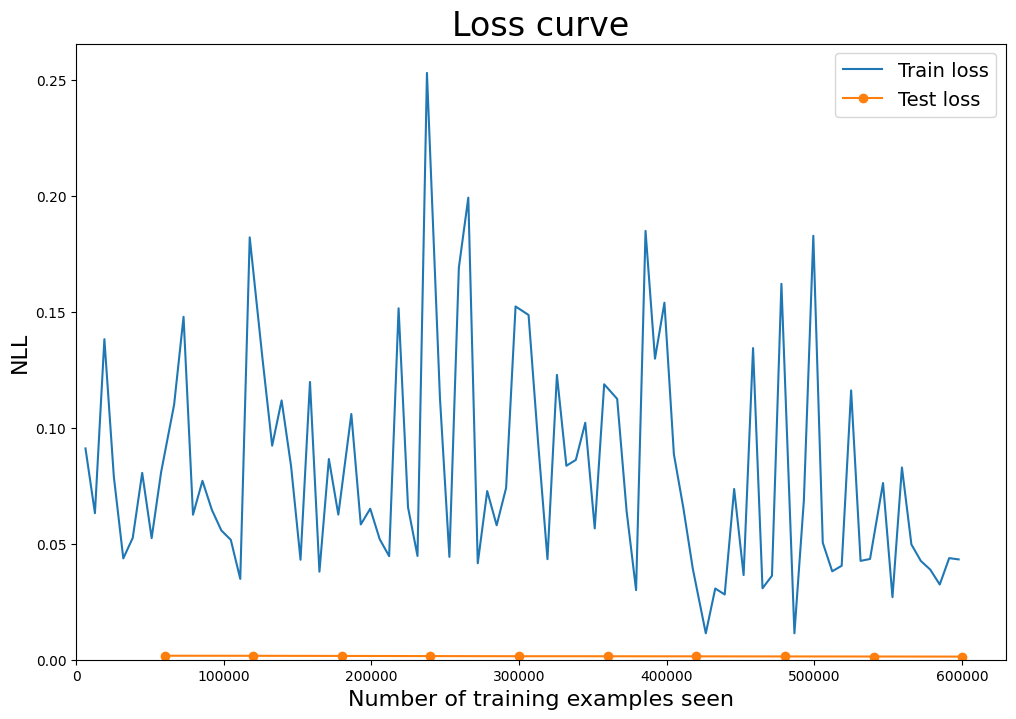

In [75]:
# 1. Draw training loss curve
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)],
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


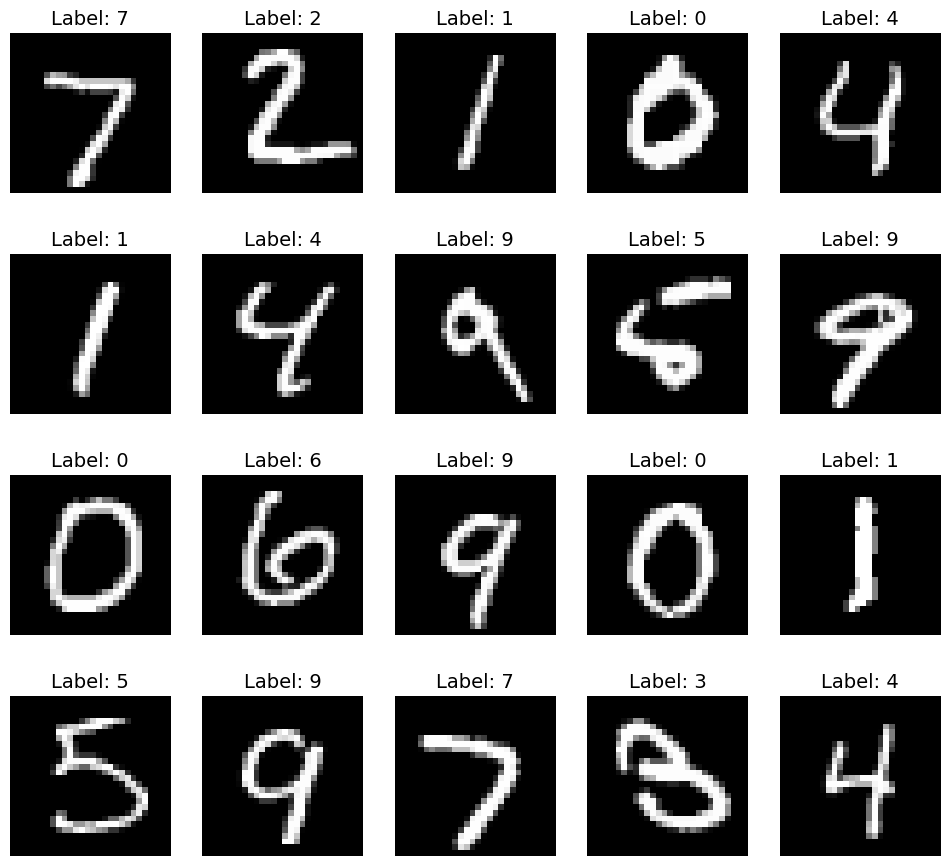

In [90]:
# 2. Show the predictions of the first 20 images of the test dataset
images, labels = next(iter(test_loader))

images, labels = images.to(DEVICE), labels.to(DEVICE)

output = model(images)
pred = output.argmax(dim=1)

fig = plt.figure(figsize=(12, 11))

# ------------------
# Write your implementation here. Use the code provided in Part 0 to visualize the images.

for i in range(0, 20):
  plt.subplot(4, 5, i+1)
  img = images[i].cpu().numpy()
  plt.imshow(img.transpose((1, 2, 0)), cmap='gray', interpolation='none')
  plt.title(f'Label: {labels[i]}', fontsize=14)
  plt.axis('off')

# ------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


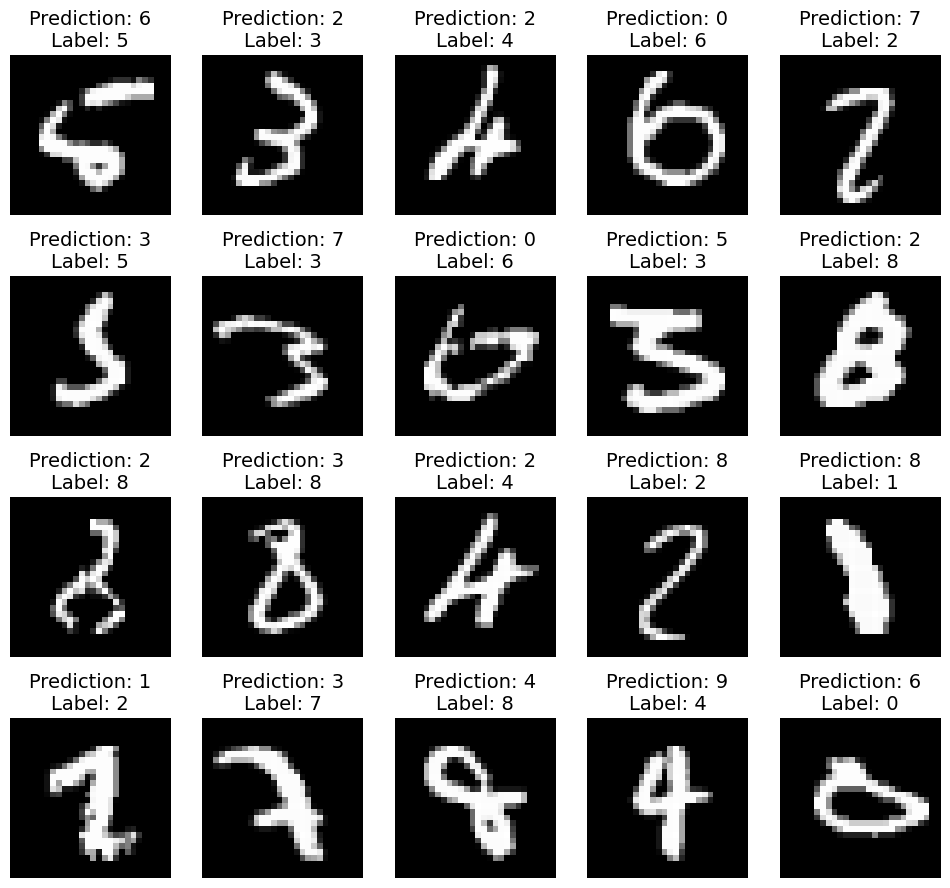

In [95]:
# 3. Get 20 incorrect predictions in test dataset

# Collect the images, predictions, labels for the first 20 incorrect predictions
# Initialize empty tensors and then keep appending to the tensor.
# Make sure that the first dimension of the tensors is the total number of incorrect
# predictions seen so far
# Ex) incorrect_imgs should be of shape i x C x H x W, where i is the total number of
# incorrect images so far.
incorrect_imgs = []
incorrect_preds = []
incorrect_labels = []

with torch.no_grad():
    # Test set iterator
    it = iter(test_loader)
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    while len(incorrect_imgs) < 20:
        images, labels = next(it)
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # ------------------
        # Write your implementation here.

        output = model(images)
        pred = output.argmax(dim=1, keepdim=True)

        mismatches = pred.squeeze() != labels

        for img, p, l in zip(images[mismatches], pred[mismatches], labels[mismatches]):
            if len(incorrect_imgs) < 20:
                incorrect_imgs.append(img)
                incorrect_preds.append(p)
                incorrect_labels.append(l)
            else:
                break

        # ------------------
# Show the first 20 wrong predictions in test set
fig = plt.figure(figsize=(12, 11))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {incorrect_preds[i].item()}\nLabel: {incorrect_labels[i].item()}', fontsize=14)
    plt.axis('off')

In [98]:
train_loss, train_accuracy = test_one_epoch(train_loader, model, DEVICE)
test_loss, test_accuracy = test_one_epoch(test_loader, model, DEVICE)

print(f"Training Data: Loss = {train_loss}, Accuracy = {(train_accuracy/len(train_loader.dataset)) * 100}%")
print(f"Test Data: Loss = {test_loss}, Accuracy = {(test_accuracy/len(test_loader.dataset)) * 100}%")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training Data: Loss = 0.0009698490515428906, Accuracy = 98.34666666666666%
Test Data: Loss = 0.001345947343634907, Accuracy = 97.44%
